# Exploration of options to improve ML model performance

## Imports and creation of display and preprocessing functions

In [73]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.cm as mpl_cm
import pandas as pd
import cv2  
from os import listdir 
from os.path import isfile, join 
import os 
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler,PolynomialFeatures 
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline 
import random 
from defisheye import Defisheye
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.svm import LinearSVC 

import joblib 



def display_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    labels = sorted(list(set(y_true))) 
    ConfusionMatrixDisplay(cm,display_labels=labels).plot()
def display_confusion_matrix_with_axis(y_true, y_pred,ax):
    cm = confusion_matrix(y_true, y_pred)
    labels = sorted(list(set(y_true))) 
    ConfusionMatrixDisplay(cm,display_labels=labels).plot(ax=ax)

class  ImagePreprocessing():
    """
    A Custom class to preform preprocessings. 

    This transformer takes an iterable of images (e.g., a list or a NumPy array)
    and resizes each image to a target size using OpenCV's cv2.resize function.

    The input `X` is expected to be a collection where each element
    is a valid image represented as a NumPy array.

    Attributes:
        height (int): The target height for the resized images.
        width (int): The target width for the resized images.
        
    """
    def __init__(self, height=64, width=64):
        self.height = height
        self.width = width


    def resize(self, X):
        """
        Resizes each image in the input iterable.
        and flatens them to a 1d representation: 
        an unflattened version maybe obtained by using the method unflaten 

        Args:
            X (iterable): The input data, expected to be an iterable of images.
                          Each element should be a NumPy array representing an image.

        Returns:
            np.ndarray: A new NumPy array containing a flattend representation of the resized images.
        """
        if not hasattr(X, '__iter__'):
            raise TypeError("Input must be an iterable (e.g., a list or NumPy array).")
        
        resized_images = []
        for i, image in enumerate(X):
            # Check if the individual item is a valid image (a NumPy array)
            if not isinstance(image, np.ndarray) or image.ndim not in [2, 3]:
                raise ValueError(f"Element at index {i} is not a valid image (expected 2D or 3D NumPy array), got {type(image)}.")

            try:
                # Resize the image using OpenCV
                resized_image = cv2.resize(image, (self.width, self.height), interpolation=cv2.INTER_CUBIC)
                resized_images.append(resized_image)
            except Exception as e:
                # This handles potential errors from cv2.resize for malformed arrays
                raise RuntimeError(f"Could not resize image at index {i}. Original shape: {image.shape}. Error: {e}")

        # It's a good practice for transformers to return a NumPy array
        # as a standard output type for subsequent steps in a pipeline.
        return np.array(resized_images)

    def flatten(self, X ): 
        flattend_images = []
        for i, image in enumerate(X):
            flattend_images.append(image.flatten())
        return np.array(flattend_images)

    def add_edgeimage(self,X): 
        if not hasattr(X, '__iter__'):
            raise TypeError("Input must be an iterable (e.g., a list or NumPy array).")
        
        rgb_gray_images = []
        for i, image in enumerate(X):
            # Check if the individual item is a valid image (a NumPy array)
            if not isinstance(image, np.ndarray) or image.ndim not in [ 3]:
                raise ValueError(f"Element at index {i} is not a valid image (expected 2D or 3D NumPy array), got {type(image)}.")

            try:
                # Resize the image using OpenCV
                grey_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #(mxn)
                # Apply Sobel operator
                sobelx = cv2.Sobel(grey_image, cv2.CV_64F, 1, 0, ksize=3)  # Horizontal edges
                sobely = cv2.Sobel(grey_image, cv2.CV_64F, 0, 1, ksize=3)  # Vertical edges
 
                # Compute gradient magnitude
                gradient_magnitude = cv2.magnitude(sobelx, sobely)
 
                # Convert to uint8
                gradient_magnitude = cv2.convertScaleAbs(gradient_magnitude)# 
                gradient_magnitude=gradient_magnitude.reshape(gradient_magnitude.shape+(1,))#(mxnx1)
                im_rgb_Edge= np.concat((image,gradient_magnitude),axis=2)#(mxnx3)+(mxnx1)=(mxnx4) (rgb gray)
                rgb_gray_images.append(im_rgb_Edge)
            except Exception as e:
                # This handles potential errors from cv2.resize for malformed arrays
                raise RuntimeError(f"Could not resize image at index {i}. Original shape: {image.shape}. Error: {e}")
        return rgb_gray_images
    
    def add_rotation_copies(self,X,y):
        augmented_images=[] 
        augmented_labels=[]
        for i, image in enumerate(X):
            height, width = image.shape[:2]
 
            # Define the rotation center
            center = (width // 2, height // 2)
 
            # Define the rotation angle
            angles = [90,180,270]  # Rotate by 45 degrees
 
            # Define the scaling factor 
            scale = 1.0  # No scaling
            augmented_images.append(image)
            augmented_labels.append(y[i])
            for angle in angles:
                # Get the rotation matrix
                rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)
 
                # Perform the rotation
                rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
                augmented_images.append(rotated_image)
                augmented_labels.append(y[i])
        return augmented_images,np.array(augmented_labels)

## load data

In [2]:
dirpath="./CCSN_v2"
class_dirs=listdir(dirpath)
lists_image_names=[]
for dir in class_dirs: 
    lists_image_names.append(listdir(dirpath+"/"+dir))


images= []
y=[] 
for  i in range(len(class_dirs)): 
    for image_name in lists_image_names[i]: 
        im=cv2.imread( dirpath+"/"+class_dirs[i]+"/"+image_name )
        images.append( im  )
        y.append(class_dirs[i])

y=np.array(y)

## exploring data set and checking rescaling works

----- data distributions -----
labels
Sc        340
Cs        287
Ns        274
Cc        268
Cb        242
Ac        221
St        202
Ct        200
As        188
Cu        182
Ci        139
Name: count, dtype: int64
--------- total images ---------
labels    2543
dtype: int64


Text(0.5, 0.98, 'resized image size distribution')

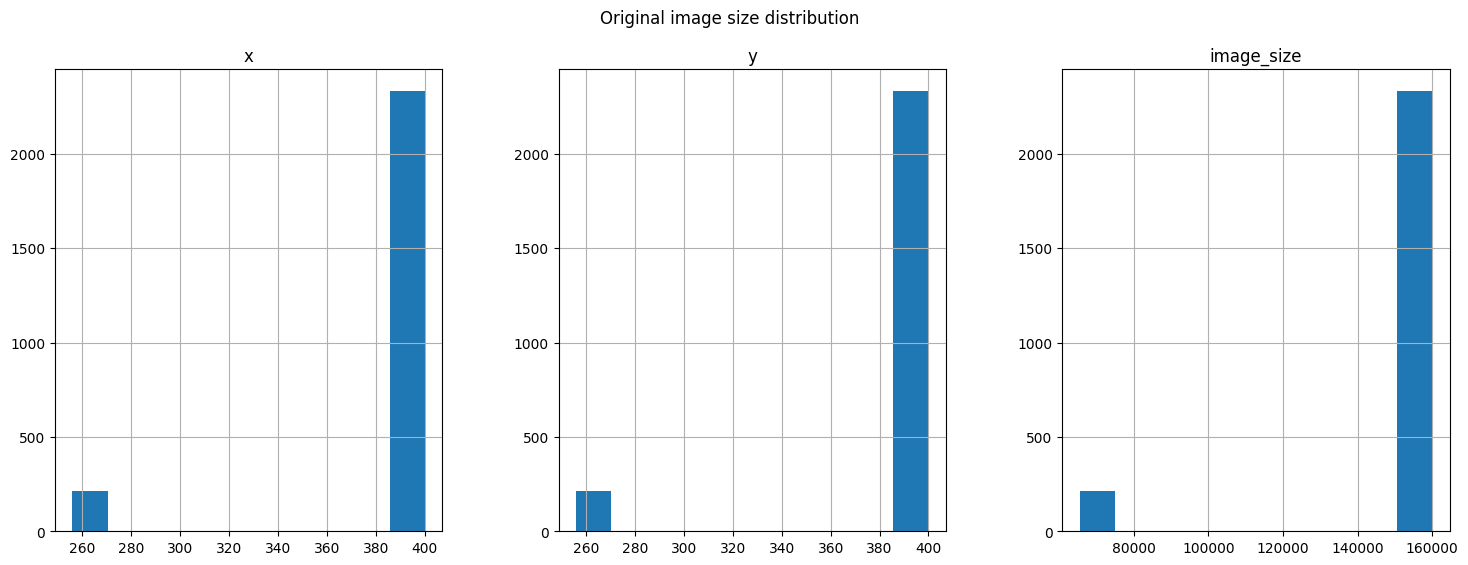

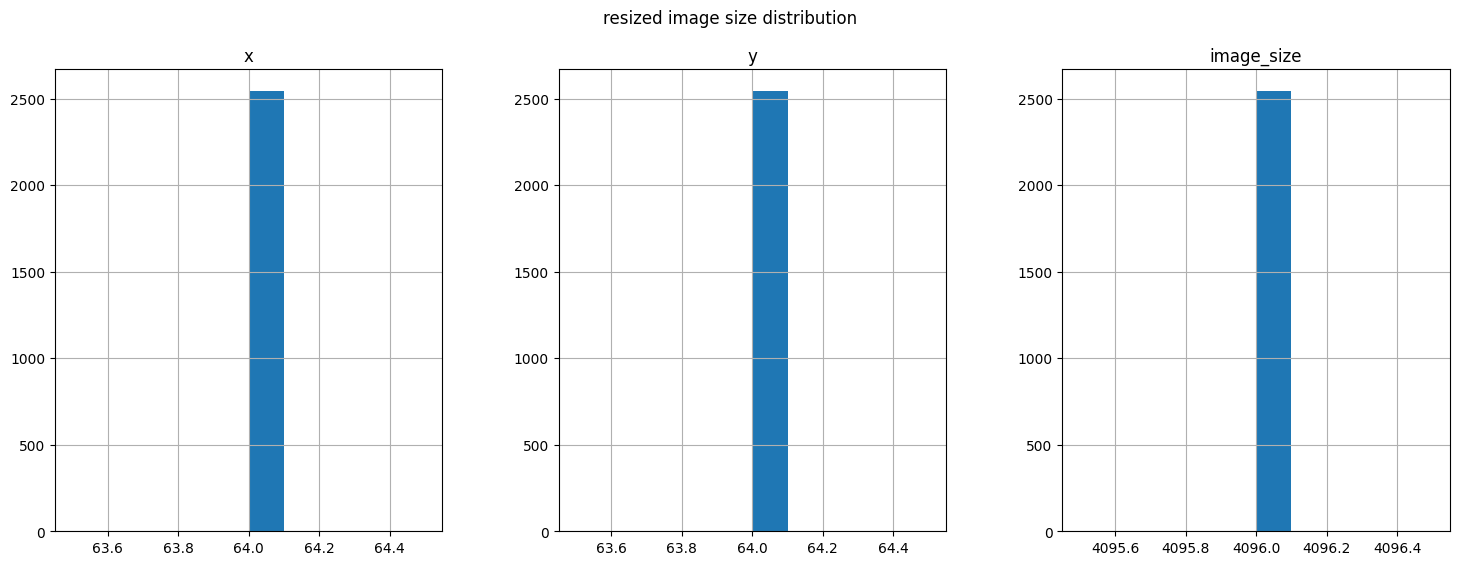

In [ ]:
y_df=pd.DataFrame(y,columns=['labels'])


print('-'*5,'data distributions','-'*5)
print(y_df.value_counts())

print('-'*9,'total images','-'*9)
print(y_df.count())



sizes=[M.shape for M in images] 
origninal_image_sizes= pd.DataFrame(sizes)
origninal_image_sizes=origninal_image_sizes.rename(columns={0: "x", 1: "y", 2: "z"})

fig, axes= plt.subplots(1,3 ,figsize=(18,6) ) 
origninal_image_sizes.hist(column="x", ax=axes[0])
origninal_image_sizes.hist(column="y", ax=axes[1])
origninal_image_sizes['image_size']= origninal_image_sizes['x']*origninal_image_sizes['y']
origninal_image_sizes.hist(column='image_size', ax=axes[2])
fig.suptitle('Original image size distribution')

nn=64
resizer = ImagePreprocessing(height=nn, width=nn)

resized_images= resizer.resize(images)
new_sizes=[M.shape for M in resized_images] 
resized_im= pd.DataFrame(new_sizes)
resized_im.head()
resized_im=resized_im.rename(columns={0: "x", 1: "y", 2: "z"})

fig2, axes2= plt.subplots(1,3 ,figsize=(18,6) ) 
resized_im.hist(column="x", ax=axes2[0])
resized_im.hist(column="y", ax=axes2[1])
resized_im['image_size']= resized_im['x']*resized_im['y']
resized_im.hist(column='image_size', ax=axes2[2])
fig2.suptitle('resized image size distribution')



## Data augmentation check that augmentation works correctly

(400, 400, 3)
['Ac' 'Ac' 'Ac' 'Ac' 'Ac' 'Ac' 'Ac' 'Ac']


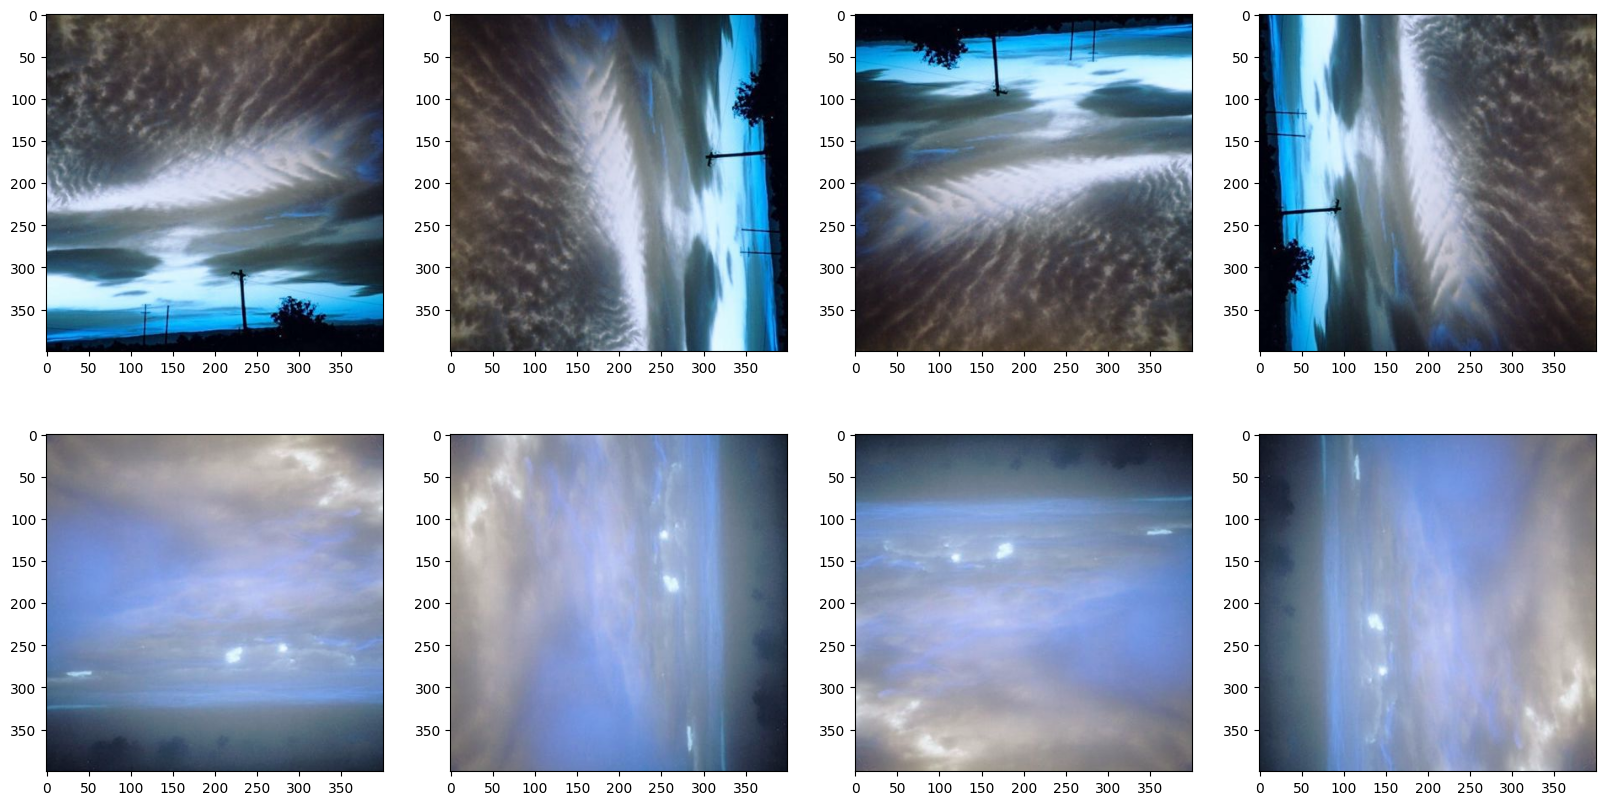

In [31]:
#example_DA that data augmentation works correctly 
example_DA= [images[0],images[1]]
print(example_DA[0].shape)

y_DA=[y[0],y[1]]
resizer= ImagePreprocessing()
test_rgbL,y_DA= resizer.add_rotation_copies(example_DA,y_DA)

fig,ax = plt.subplots(2,4, figsize=(20,10))
ax=ax.flatten()

for i in range(8): 
     ax[i].imshow(test_rgbL[i])
print(y_DA)

## Test how training performance is effected by using data augmentation

---------- Orignal data set ----------
              precision    recall  f1-score   support

          Ac       0.16      0.12      0.14        42
          As       0.48      0.40      0.44        35
          Cb       0.38      0.47      0.42        58
          Cc       0.29      0.42      0.34        53
          Ci       0.40      0.14      0.21        29
          Cs       0.30      0.27      0.29        51
          Ct       0.50      0.64      0.56        45
          Cu       0.19      0.07      0.11        41
          Ns       0.27      0.33      0.29        52
          Sc       0.43      0.57      0.49        69
          St       0.40      0.18      0.24        34

    accuracy                           0.35       509
   macro avg       0.34      0.33      0.32       509
weighted avg       0.34      0.35      0.34       509

0.35363457760314343
---------- Augmented data set ----------
              precision    recall  f1-score   support

          Ac       0.32      0.1

Text(0.5, 1.0, 'Augmented')

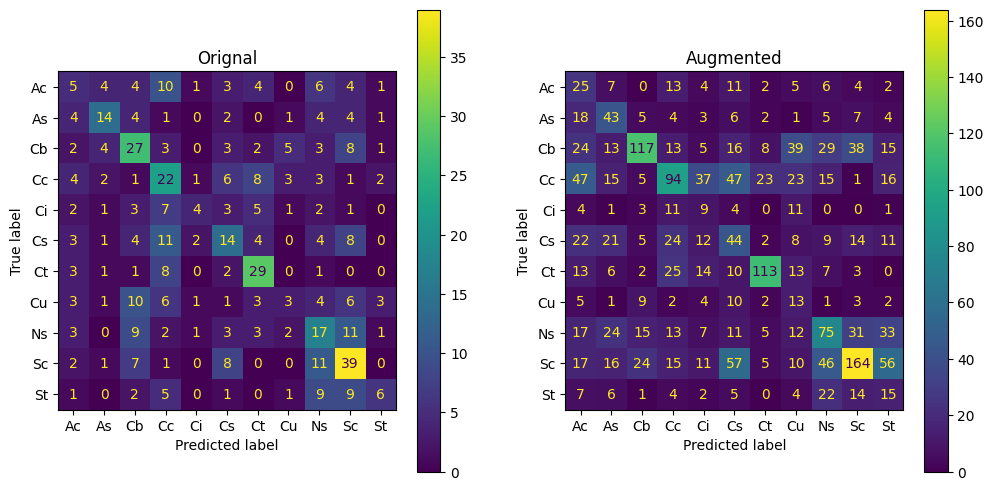

In [75]:


preprocesser=ImagePreprocessing(64,64)
images_original_set= preprocesser.resize(images)
augmented_image_set, augmented_y=preprocesser.add_rotation_copies(images_original_set,y)

images_original_set= preprocesser.flatten(images_original_set)
augmented_image_set=preprocesser.flatten(augmented_image_set)

X_original_set,X_original_set_test, y_original_set,y_original_set_test=train_test_split(images_original_set,y ,test_size=0.2 ,random_state=42)
X_augmented,X_augmented_test, y_augmented,y_augmented_test=train_test_split(augmented_image_set,augmented_y ,test_size=0.2 ,random_state=42)




ET_original_set = Pipeline(steps=[('StandardScaler',StandardScaler()),('ET-CLF',ExtraTreesClassifier(random_state=21) ) ]) 
ET_original_set.fit(X_original_set, y_original_set) 
y_original_pred_test= ET_original_set.predict(X_original_set_test)

print('-'*10,'Orignal data set','-'*10)
print(classification_report(y_original_set_test, y_original_pred_test))
print(accuracy_score(y_original_set_test, y_original_pred_test))


ET_augmented = Pipeline(steps=[('StandardScaler',StandardScaler()),('ET-CLF',ExtraTreesClassifier(random_state=21) ) ]) 
ET_augmented.fit(X_augmented, y_augmented) 
y_augmented_pred_test= ET_augmented.predict(X_augmented_test)

print('-'*10,'Augmented data set','-'*10)
print(classification_report(y_augmented_test, y_augmented_pred_test))
print(accuracy_score(y_augmented_test, y_augmented_pred_test))
fig,axes=plt.subplots(1,2,figsize=(12,6))
display_confusion_matrix_with_axis(y_original_set_test, y_original_pred_test,ax=axes[0]) 
display_confusion_matrix_with_axis(y_augmented_pred_test, y_augmented_test,ax=axes[1]) 
axes[0].set_title('Orignal')
axes[1].set_title('Augmented')


## Adding Custom features - Edges of the image

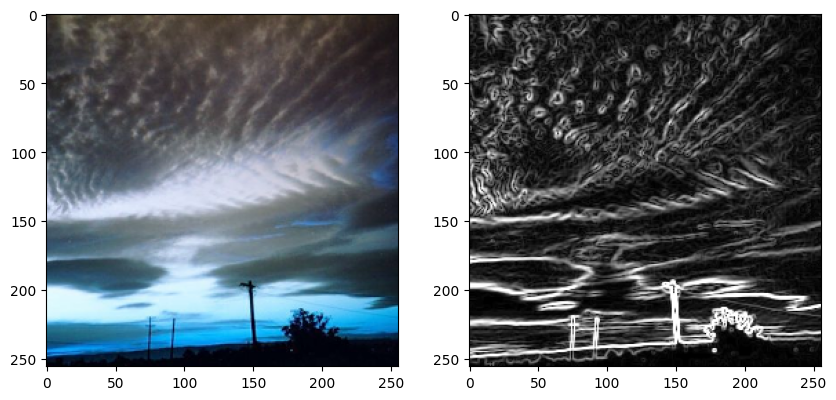

In [ ]:
#visualisation 
nn=256
preprocesser=ImagePreprocessing(nn,nn)
images_original_set= preprocesser.resize(images)
images_with_edges=preprocesser.add_edgeimage(images_original_set) 
ex_image= images_with_edges[0]
fig,axes=plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(ex_image[:,:,0:3])
axes[1].imshow(ex_image[:,:,3],cmap='Greys_r')


---------- Features from RGB changel ----------
              precision    recall  f1-score   support

          Ac       0.22      0.10      0.14        41
          As       0.33      0.24      0.28        38
          Cb       0.29      0.54      0.38        41
          Cc       0.33      0.52      0.41        60
          Ci       0.00      0.00      0.00        28
          Cs       0.25      0.16      0.19        57
          Ct       0.53      0.71      0.60        41
          Cu       0.33      0.19      0.24        37
          Ns       0.25      0.34      0.29        53
          Sc       0.36      0.46      0.41        69
          St       0.31      0.09      0.14        44

    accuracy                           0.32       509
   macro avg       0.29      0.30      0.28       509
weighted avg       0.30      0.32      0.29       509

---------- Features from RGB changel+edge images ----------
              precision    recall  f1-score   support

          Ac       0.23 

Text(0.5, 1.0, 'with additional edge image')

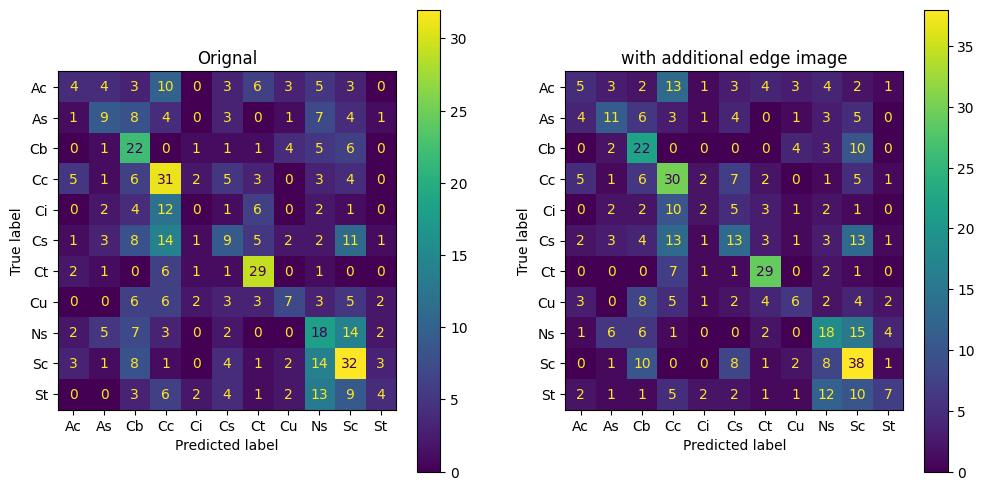

In [ ]:
nn=64
preprocesser=ImagePreprocessing(nn,nn)
images_original_set= preprocesser.resize(images)
images_with_edges=preprocesser.add_edgeimage(images_original_set) 
images_with_edges= preprocesser.flatten(images_with_edges)
X_train, X_test,y_train,y_test=train_test_split(images_with_edges,y, test_size=0.2 ,random_state=21)
scaler=StandardScaler()
scaler2=StandardScaler()


X_train_3ch=scaler.fit_transform(X_train[:,0:nn**2*3] )
X_test_3ch=scaler.transform(X_test[:,0:nn**2*3] )

X_train_4ch=scaler2.fit_transform(X_train)
X_test_4ch=scaler2.transform(X_test )


ET_3ch= ExtraTreesClassifier(random_state=21)
ET_4ch= ExtraTreesClassifier(random_state=21)

ET_3ch.fit(X_train_3ch,y_train)
ET_4ch.fit(X_train_4ch,y_train)

y_pred_3ch= ET_3ch.predict(X_test_3ch)
y_pred_4ch= ET_4ch.predict(X_test_4ch)


print('-'*10,'Features from RGB changel','-'*10)
print(classification_report(y_test, y_pred_3ch))
print(ET_3ch.score())
print('-'*10,'Features from RGB changel+edge images','-'*10)
print(classification_report(y_test, y_pred_4ch))

fig,axes=plt.subplots(1,2,figsize=(12,6))
display_confusion_matrix_with_axis(y_test, y_pred_3ch ,ax=axes[0]) 
display_confusion_matrix_with_axis(y_test, y_pred_4ch,ax=axes[1]) 
axes[0].set_title('Orignal')
axes[1].set_title('with additional edge image')




## Importance of the different the image channels for the prediction different channels

relative importance of the differenet color chanels
Red :0.24529004356340253
Blue :0.2500628352252667
Green :0.2540058057510863
Edge :0.2506413154602449


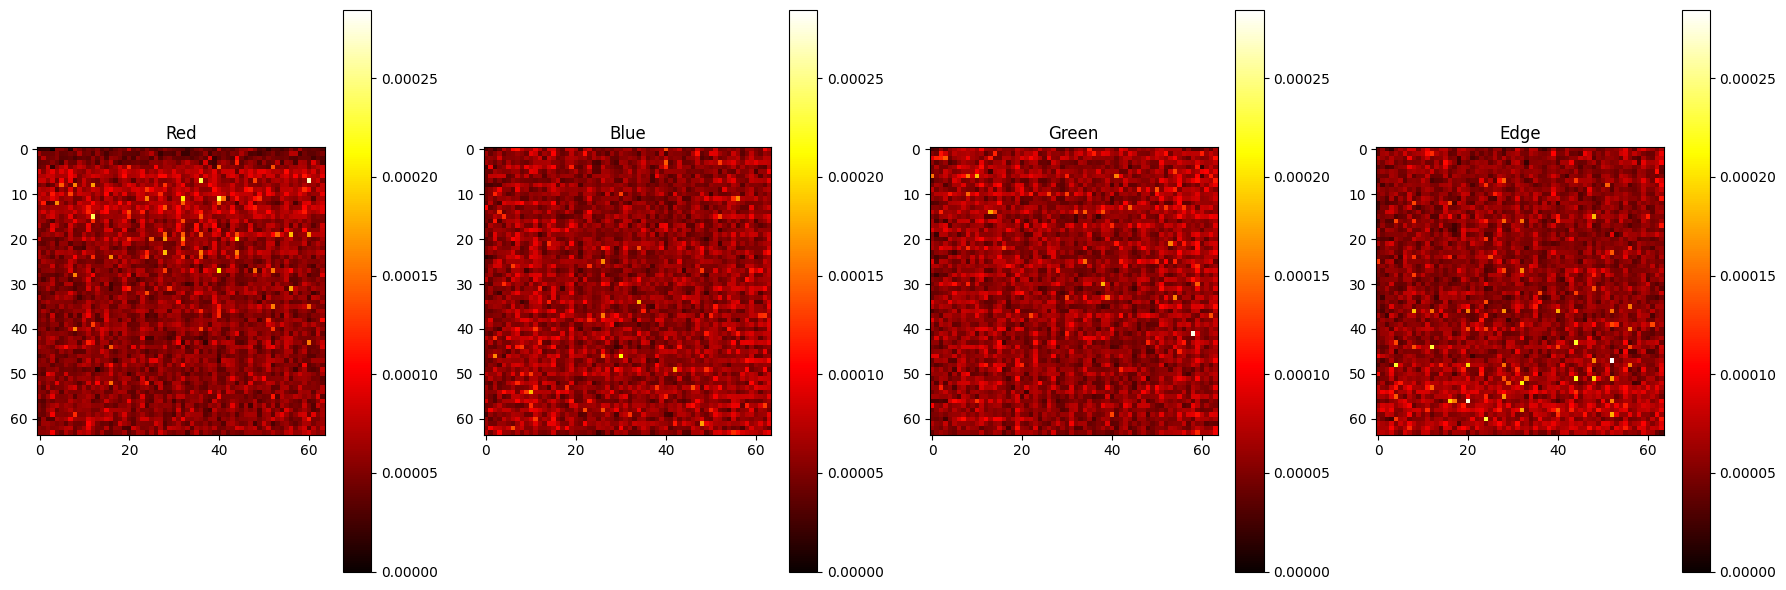

In [81]:
def plot_digit(data,n,ax , min, max):
    image = data.reshape(n, n)
    im=ax.imshow(image, cmap=mpl_cm.hot, interpolation="nearest",vmin=min,vmax=max)
    
    plt.colorbar(im, ax=ax)
    return sum(data)


nn=64
preprocesser=ImagePreprocessing(nn,nn)
images_original_set= preprocesser.resize(images)
images_with_edges=preprocesser.add_edgeimage(images_original_set) 
augmented_images_4ch,y_4ch= preprocesser.add_rotation_copies(images_with_edges,y)
X_4ch= preprocesser.flatten(augmented_images_4ch)


importance=[] 




ET_augmented_4ch= ExtraTreesClassifier(random_state=21)

ET_augmented_4ch.fit(X_4ch,y_4ch)

feature_importance=ET_augmented_4ch.feature_importances_





min=np.min(feature_importance)
max=np.max(feature_importance)

colors_layers= ["Red","Blue","Green","Edge"]
n_colors=len(colors_layers)
fig,axes= plt.subplots(1,n_colors, figsize=(18,6))
for i in range(n_colors): 
    sigma= plot_digit(feature_importance[nn**2*i:nn**2*(i+1)],nn ,axes[i],min,max)
    axes[i].set_title(colors_layers[i]) 
    importance.append(sigma)


fig.tight_layout()


print("relative importance of the differenet color chanels")
for i in range(n_colors): 
    print(colors_layers[i], f":{importance[i]}")



## Feature selection 

In [83]:

def preprocessing_flow(n,n_comp , images,y): 
    imResizer=ImagePreprocessing(height=n, width=n)
    images_rgb_gray= imResizer.add_edgeimage(images)
    resized_images= imResizer.resize(images_rgb_gray)
    augmented_resized_images,augmented_y =imResizer.add_rotation_copies(resized_images,y)
    images_training_data= imResizer.flatten(augmented_resized_images)
    X_train_val, X_test, y_train_val , y_test =train_test_split(images_training_data, augmented_y ,test_size=0.1 ,random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val,y_train_val, test_size=0.2, random_state=42)
    rescaler=StandardScaler() 
    X_train=rescaler.fit_transform(X_train)
    X_val=rescaler.transform(X_val)
    X_test=rescaler.transform(X_test)

    pca=PCA(n_components=n_comp, random_state=42) 
    #pca=KernelPCA(n_components=n_comp,kernel="cosine", random_state=42 ) 
    X_train=pca.fit_transform(X_train) 
    X_val=pca.transform(X_val) 
    X_test=pca.transform(X_test) 
    
    return X_train,X_val,X_test,y_train,y_val, y_test , X_train_val,y_train_val

Text(0.5, 1.0, 'log')

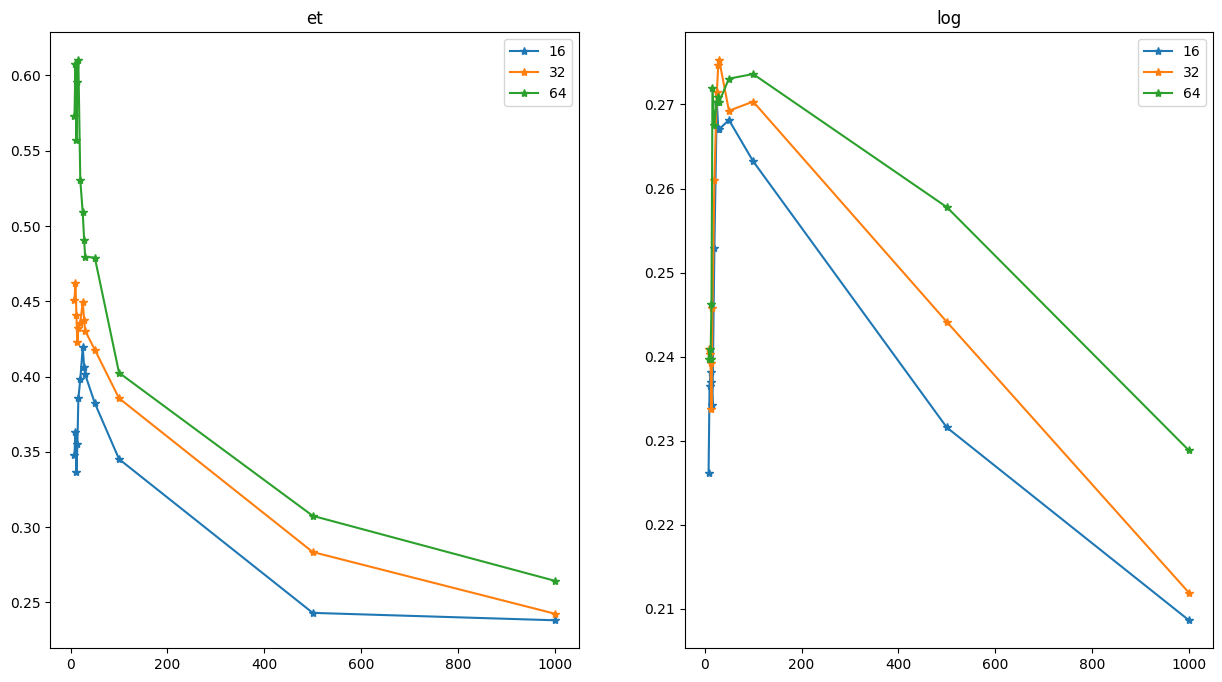

In [84]:
ns=[16,32,64]
n_comps= [8,10,12,14,16,20,25,28,30,50,100, 500 ,1000]

scores_image_sizes_et= []
scores_image_sizes_log= []

for n in ns: 
    scores_et=[]
    scores_log=[]
    for n_comp in n_comps: 

        X_train,X_val,X_test,y_train,y_val, y_test , X_train_val,y_train_val=preprocessing_flow(n,n_comp,images,y )

        extra_trees_clf = ExtraTreesClassifier(n_estimators=100,random_state=21, n_jobs=-1)
        logreg_clf = LogisticRegression(max_iter=1000, n_jobs=-1)
    # et_clf_gray = ExtraTreesClassifier(n_estimators=100,random_state=21, n_jobs=-1)

        extra_trees_clf.fit(X_train,y_train)
        logreg_clf.fit(X_train,y_train)
        score_et=extra_trees_clf.score(X_val,y_val)
        score_log=logreg_clf.score(X_val,y_val)
        scores_et.append(score_et)
        scores_log.append(score_log)

    scores_image_sizes_et.append(scores_et)
    scores_image_sizes_log.append(scores_log)

fig,ax= plt.subplots(1,2,figsize=(15,8) )

for i in range(len(ns)): 
    ax[0].plot(n_comps,scores_image_sizes_et[i], '-*',label=f"{ns[i]}"  )
    ax[1].plot(n_comps,scores_image_sizes_log[i],'-*' ,label=f"{ns[i]}" )
ax[0].legend()
ax[0].set_title('et')
ax[1].legend()
ax[1].set_title('log')